In [19]:
%%html
<style>
table {float:left}
td, tr {font-size:20px}
</style>

In [1]:
import numpy as np
import tensorflow as tf
from numpy import newaxis
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

class GameAgent:
    def __init__(self, n_actions, n_features, reward_decay=0.99,
                 learning_rate=0.01, learning_rate_decay=0.95,
                 ):
        self.state_size = n_features
        self.action_size = n_actions
        self.gamma = reward_decay   # discount rate
        self.learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.batch_size = 64
        self.epsilon = 0.2 # used to clip
        self.epsilon_greedy = 0.02 # used in epsilon greedy strategy
        self.entfact = 1e-2 # entropy factor, to encourage exploration
        self.lam = 0.95 # gae factor
        self.memory = [] # store (s, a, r) for one agent
        self.agents = 5 # number of agents that collect memory
        self.history = {} # store the memory for different agents
        self.history['states'] = []
        self.history['actions'] = []
        self.history['oppo_states'] = []
        self.history['oppo_actions'] = []
        self.history['discounted_rs'] = []
#         self.losses = []
#         self.joint_probas = []
        self._construct_nets()
        
    def _construct_nets(self):
        tf.reset_default_graph()
        self.sess = tf.Session()
        self.tfs = tf.placeholder(tf.float32, [None, self.state_size], 'state')

        # actor
        pi = self._build_anet('pi', trainable=True)
        oldpi = self._build_anet('oldpi', trainable=False)
        with tf.variable_scope('pi'):
            self.pi_probs = tf.nn.softmax(pi)
        with tf.variable_scope('oldpi'):
            self.oldpi_probs = tf.nn.softmax(oldpi)
        pi_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='pi')
        oldpi_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='oldpi')
        with tf.variable_scope('sample_action'):
            self.sample_op = tf.squeeze(tf.multinomial(pi, 1), axis=0)       # choosing action
            self.sample_op_old = tf.squeeze(tf.multinomial(oldpi, 1), axis=0)
        with tf.variable_scope('update_oldpi'):
            self.update_oldpi_op = [oldp.assign(p) for p, oldp in zip(pi_params, oldpi_params)]

        self.tfa = tf.placeholder(tf.int32, [None], 'action')
        self.tfa_oppo = tf.placeholder(tf.int32, [None], 'action_oppo')
        self.tfa_one_hot = tf.contrib.layers.one_hot_encoding(self.tfa, self.action_size)
        self.tfa_oppo_one_hot = tf.contrib.layers.one_hot_encoding(self.tfa_oppo, self.action_size)
        
        self.tfdc_r = tf.placeholder(tf.float32, [None], name="payoff")
        self.oppo_pi_probs = tf.placeholder(tf.float32, [None, self.action_size], name="oppo_pi")

        self.joint_proba = tf.reduce_sum(self.pi_probs * self.tfa_one_hot, axis=1) * tf.reduce_sum(self.oppo_pi_probs * self.tfa_oppo_one_hot, axis=1)
        self.loss = - tf.reduce_sum(self.tfdc_r * self.joint_proba)

        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss, var_list=pi_params)

        self.saver = tf.train.Saver(max_to_keep=None)
        
        self.sess.run(tf.global_variables_initializer())
        
    def _build_anet(self, name, trainable):
        with tf.variable_scope(name):
            net = tf.layers.dense(self.tfs, 10, tf.nn.relu, trainable=trainable)
            logits = tf.layers.dense(net, self.action_size, trainable=trainable)
        return logits
    
    def choose_action(self, state, old=False): # epsilon greedy strategy
        rand = np.random.uniform(0,1,1)[0]
        if rand < self.epsilon_greedy:
            return np.random.randint(self.action_size, size=1)[0]
        if old:
            return self.sess.run(self.sample_op_old, {self.tfs: state})[0]
        return self.sess.run(self.sample_op, {self.tfs: state})[0]
    
    def remember(self, state, oppo_state, action, oppo_action, reward):
        self.memory += [[state[0], oppo_state[0], action, oppo_action, reward]]
    
    def discount_rewards(self, rewards, gamma, value_next=0.0):
        discounted_r = np.zeros_like(rewards)
        running_add = value_next
        for t in reversed(range(0, len(rewards))):
            discounted_r[t] = running_add = running_add * gamma + rewards[t]
        return discounted_r
    
    def process_memory(self):
        memory = np.vstack(self.memory)
        states = np.vstack(memory[:,0])
        oppo_states = np.vstack(memory[:,1])
        actions = memory[:,2]
        oppo_actions = memory[:,3]
        rewards = memory[:,4]
#         discounted_ep_rs = self.discount_rewards(rewards, self.gamma)[:, newaxis]
        self.history['states'] += [states]
        self.history['actions'] += [actions]
        self.history['oppo_states'] += [oppo_states]
        self.history['oppo_actions'] += [oppo_actions]
        self.history['discounted_rs'] += [rewards]
        self.memory = [] # empty the memory
    
    def replay(self, K=10):
        self.sess.run(self.update_oldpi_op)
        
        s = np.vstack(self.history['states'])
        ac = np.vstack(self.history['actions']).flatten()
        os = np.vstack(self.history['oppo_states'])
        oa = np.vstack(self.history['oppo_actions']).flatten()
        dc_r = np.vstack(self.history['discounted_rs']).flatten()
        
        for _ in range(K): # update K epochs
            s, ac, os, oa, dc_r = shuffle(s, ac, os, oa, dc_r)
            for l in range(s.shape[0]//self.batch_size):
                start = l * self.batch_size
                end = (l + 1) * self.batch_size
                oppo_pi_probs = self.sess.run(self.oldpi_probs, {self.tfs: os[start:end]})
                self.sess.run(self.train_op, {self.tfs: s[start:end], self.tfa: ac[start:end], self.oppo_pi_probs: oppo_pi_probs, self.tfa_oppo: oa[start:end], self.tfdc_r: dc_r[start:end]})
#                 self.losses += [self.sess.run(self.loss, {self.tfs: s[start:end], self.tfa: ac[start:end], self.oppo_pi_probs: oppo_pi_probs, self.tfa_oppo: oa[start:end], self.tfdc_r: dc_r[start:end]})]
            if s.shape[0] % self.batch_size != 0:
                res = s.shape[0] % self.batch_size
                oppo_pi_probs = self.sess.run(self.oldpi_probs, {self.tfs: os[-res:]})
                self.sess.run(self.train_op, {self.tfs: s[-res:], self.tfa: ac[-res:], self.oppo_pi_probs: oppo_pi_probs, self.tfa_oppo: oa[-res:], self.tfdc_r: dc_r[-res:]})
#                 self.losses += [self.sess.run(self.loss, {self.tfs: s[-res:], self.tfa: ac[-res:], self.oppo_pi_probs: oppo_pi_probs, self.tfa_oppo: oa[-res:], self.tfdc_r: dc_r[-res:]})]
        
        for key in self.history:
            self.history[key] = [] # empty the history

In [2]:
agent = GameAgent(n_actions=2, n_features=2, learning_rate=1e-5)

# Matching pennies game, the first player (state = [0,1]) wins if their coins match

  | 0    | 1    |
 ------|------|------|
 0     |   (1,-1)  | (-1,1)|
 1     |   (-1,1)  | (1,-1)|

### If the second player always plays the same side (side 0)

In [4]:
oppo = 0
state = [[0,1]]
p = agent.sess.run(agent.pi_probs, {agent.tfs: state})[0]
proba0 = [p[0]]
proba1 = [p[1]]
for ep in range(2000):
    action = agent.choose_action(state)
    if action == oppo:
        reward = 1
    else:
        reward = -1
    agent.remember(state, [action], reward)
    
    agent.process_memory()
    if (ep+1) % 5 == 0:
        agent.replay()
    if (ep+1) % 10 == 0:
        p = agent.sess.run(agent.pi_probs, {agent.tfs: state})[0]
        proba0 += [p[0]]
        proba1 += [p[1]]

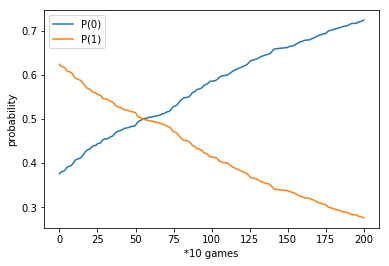

In [5]:
plt.plot(proba0, label="P(0)")
plt.plot(proba1, label="P(1)")
plt.xlabel('*10 games')
plt.ylabel('probability')
plt.legend(loc='best')
plt.show()

### The probability of choosing 0 (P(0)) increases

____
### Now, if the opponent changes the strategy, always plays side 1

In [6]:
oppo = 1
state = [[0,1]]
p = agent.sess.run(agent.pi_probs, {agent.tfs: state})[0]
proba0 = [p[0]]
proba1 = [p[1]]
for ep in range(2000):
    action = agent.choose_action(state)
    if action == oppo:
        reward = 1
    else:
        reward = -1
    agent.remember(state, [action], reward)
    agent.process_memory()
    if (ep+1) % 5 == 0:
        agent.replay()
    if (ep+1) % 10 == 0:
        p = agent.sess.run(agent.pi_probs, {agent.tfs: state})[0]
        proba0 += [p[0]]
        proba1 += [p[1]]

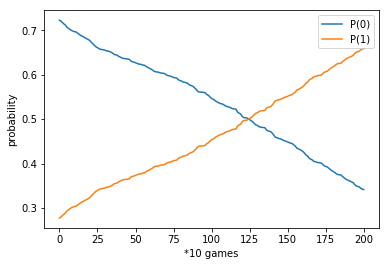

In [14]:
plt.plot(proba0, label="P(0)")
plt.plot(proba1, label="P(1)")
plt.xlabel('*10 games')
plt.ylabel('probability')
plt.legend(loc='best')
plt.show()

### The probability of choosing 1 (P(1)) increases

____
## Now, play against itself (The second player's state is [1,0])

In [9]:
agent = GameAgent(n_actions=2, n_features=2, learning_rate=7e-3)

In [10]:
state = [[0,1]]
oppo_state = [[1,0]]
p = agent.sess.run(agent.pi_probs, {agent.tfs: state})[0]
p_ = agent.sess.run(agent.pi_probs, {agent.tfs: oppo_state})[0]
player1_proba0 = [p[0]]
player2_proba0 = [p_[0]]
losses = []
eps = 500

for ep in range(eps):
    agent.remember(state, oppo_state, 0, 0, 1)
    agent.remember(state, oppo_state, 0, 1, -1)
    agent.remember(state, oppo_state, 1, 0, -1)
    agent.remember(state, oppo_state, 1, 1, 1)
    agent.process_memory()
    agent.replay(2)
    
    agent.remember(oppo_state, state, 0, 0, -1)
    agent.remember(oppo_state, state, 0, 1, 1)
    agent.remember(oppo_state, state, 1, 0, 1)
    agent.remember(oppo_state, state, 1, 1, -1)
    agent.process_memory()  
    agent.replay(3)
    
    p = agent.sess.run(agent.pi_probs, {agent.tfs: state})[0]
    p_ = agent.sess.run(agent.pi_probs, {agent.tfs: oppo_state})[0]
    oppo_pi_probs = agent.sess.run(agent.pi_probs, {agent.tfs: oppo_state})
    player1_proba0 += [p[0]]
    player2_proba0 += [p_[0]]
    losses += [-agent.sess.run(agent.loss, {agent.tfs: state, agent.oppo_pi_probs: oppo_pi_probs, 
                         agent.tfa: [0,0,1,1], agent.tfa_oppo:[0,1,0,1], agent.tfdc_r: [1,-1,-1,1]})]

In [11]:
print('optimal strategy :')
print('P1(0) =', np.mean(player1_proba0))
print('P2(0) =', np.mean(player2_proba0))

optimal strategy :
P1(0) = 0.499221
P2(0) = 0.49968


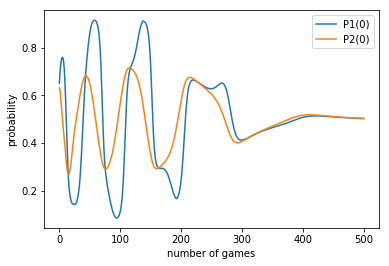

In [12]:
plt.plot(player1_proba0, label="P1(0)")
plt.plot(player2_proba0, label="P2(0)")
plt.xlabel('number of games')
plt.ylabel('probability')
plt.legend(loc='best')
plt.show()

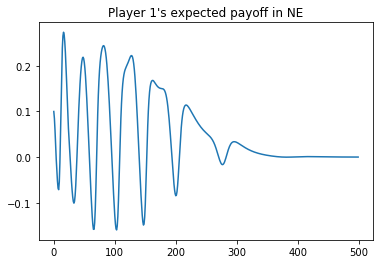

expected reward = 0.000486535


In [17]:
plt.plot(losses)
plt.title("Player 1's expected payoff in NE")
plt.show()
print('expected reward =',np.mean(losses[-100:]))

# The strategies converge to the mixed strategy NE!!

In [18]:
agent.saver.save(agent.sess, "model/matching_pennies_self_play500.ckpt");

INFO:tensorflow:model/matching_pennies_self_play500.ckpt is not in all_model_checkpoint_paths. Manually adding it.


____
## If we tweak the rewards (|reward|=2 if both players play 0)

  | 0    | 1    |
 ------|------|------|
 0     |   (2,-2)  | (-1,1)|
 1     |   (-1,1)  | (1,-1)|

In [28]:
agent = GameAgent(n_actions=2, n_features=2, learning_rate=1e-2)

In [29]:
state = [[0,1]]
oppo_state = [[1,0]]
p = agent.sess.run(agent.pi_probs, {agent.tfs: state})[0]
p_ = agent.sess.run(agent.pi_probs, {agent.tfs: oppo_state})[0]
player1_proba0 = [p[0]]
player2_proba0 = [p_[0]]
losses = []
eps = 500

for ep in range(eps):
    agent.remember(state, oppo_state, 0, 0, 2)
    agent.remember(state, oppo_state, 0, 1, -1)
    agent.remember(state, oppo_state, 1, 0, -1)
    agent.remember(state, oppo_state, 1, 1, 1)
    agent.process_memory()
    agent.replay(2)
    
    agent.remember(oppo_state, state, 0, 0, -2)
    agent.remember(oppo_state, state, 0, 1, 1)
    agent.remember(oppo_state, state, 1, 0, 1)
    agent.remember(oppo_state, state, 1, 1, -1)
    agent.process_memory()  
    agent.replay(3)
    
    p = agent.sess.run(agent.pi_probs, {agent.tfs: state})[0]
    p_ = agent.sess.run(agent.pi_probs, {agent.tfs: oppo_state})[0]
    oppo_pi_probs = agent.sess.run(agent.pi_probs, {agent.tfs: oppo_state})
    losses += [-agent.sess.run(agent.loss, {agent.tfs: state, agent.oppo_pi_probs: oppo_pi_probs, 
                         agent.tfa: [0,0,1,1], agent.tfa_oppo:[0,1,0,1], agent.tfdc_r: [2,-1,-1,1]})]
    player1_proba0 += [p[0]]
    player2_proba0 += [p_[0]]

In [30]:
print('optimal strategy :')
print('P1(0) =', np.mean(player1_proba0))
print('P2(0) =', np.mean(player2_proba0))

optimal strategy :
P1(0) = 0.391075
P2(0) = 0.382879


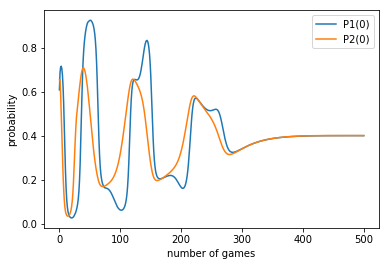

In [31]:
plt.plot(player1_proba0, label="P1(0)")
plt.plot(player2_proba0, label="P2(0)")
plt.xlabel('number of games')
plt.ylabel('probability')
plt.legend(loc='best')
plt.show()

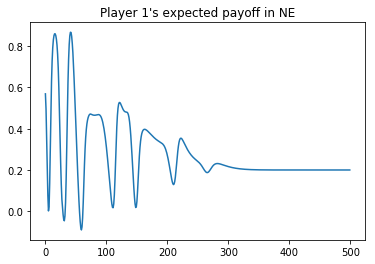

expected reward = 0.200004


In [33]:
plt.plot(losses)
plt.title("Player 1's expected payoff in NE")
plt.show()
print('expected reward =',np.mean(losses[-100:]))

# The strategies still converge to the mixed strategy NE!!

In [34]:
agent.saver.save(agent.sess, "model/matching_pennies_self_play_tweaked.ckpt");

INFO:tensorflow:model/matching_pennies_self_play_tweaked.ckpt is not in all_model_checkpoint_paths. Manually adding it.


____
Other games in https://www.aaai.org/Papers/JAIR/Vol33/JAIR-3314.pdf

# Coordination game

  | 0    | 1    |
 ------|------|------|
 0     |   (2,1)  | (0,0)|
 1     |   (0,0)  | (1,2)|

In [39]:
agent = GameAgent(n_actions=2, n_features=2, learning_rate=1e-2)

In [40]:
state = [[0,1]]
oppo_state = [[1,0]]
p = agent.sess.run(agent.pi_probs, {agent.tfs: state})[0]
p_ = agent.sess.run(agent.pi_probs, {agent.tfs: oppo_state})[0]
player1_proba0 = [p[0]]
player2_proba0 = [p_[0]]
losses = []
eps = 500

for ep in range(eps):
    agent.remember(state, oppo_state, 0, 0, 2)
    agent.remember(state, oppo_state, 0, 1, 0)
    agent.remember(state, oppo_state, 1, 0, 0)
    agent.remember(state, oppo_state, 1, 1, 1)
    agent.process_memory()
    agent.replay(2)
    
    agent.remember(oppo_state, state, 0, 0, 1)
    agent.remember(oppo_state, state, 0, 1, 0)
    agent.remember(oppo_state, state, 1, 0, 0)
    agent.remember(oppo_state, state, 1, 1, 2)
    agent.process_memory()  
    agent.replay(3)
    
    p = agent.sess.run(agent.pi_probs, {agent.tfs: state})[0]
    p_ = agent.sess.run(agent.pi_probs, {agent.tfs: oppo_state})[0]
    oppo_pi_probs = agent.sess.run(agent.pi_probs, {agent.tfs: oppo_state})
    losses += [-agent.sess.run(agent.loss, {agent.tfs: state, agent.oppo_pi_probs: oppo_pi_probs, 
                         agent.tfa: [0,0,1,1], agent.tfa_oppo:[0,1,0,1], agent.tfdc_r: [2,0,0,1]})]
    player1_proba0 += [p[0]]
    player2_proba0 += [p_[0]]

In [43]:
print('optimal strategy :')
print('P1(0) =', np.mean(player1_proba0))
print('P2(0) =', np.mean(player2_proba0))

optimal strategy :
P1(0) = 0.00204015
P2(0) = 0.00260674


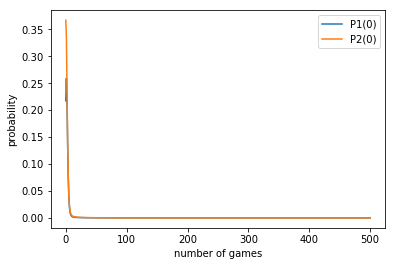

In [41]:
plt.plot(player1_proba0, label="P1(0)")
plt.plot(player2_proba0, label="P2(0)")
plt.xlabel('number of games')
plt.ylabel('probability')
plt.legend(loc='best')
plt.show()

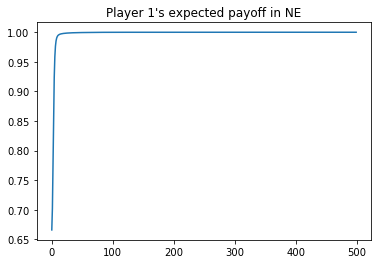

expected reward = 0.999994


In [42]:
plt.plot(losses)
plt.title("Player 1's expected payoff in NE")
plt.show()
print('expected reward =',np.mean(losses[-100:]))

# The result is one of the pure NEs, the upper left corner

____
# Tricky game

  | 0    | 1    |
 ------|------|------|
 0     |   (0,3)  | (3,2)|
 1     |   (1,0)  | (2,1)|

In [44]:
agent = GameAgent(n_actions=2, n_features=2, learning_rate=1e-5)

In [51]:
state = [[0,1]]
oppo_state = [[1,0]]
p = agent.sess.run(agent.pi_probs, {agent.tfs: state})[0]
p_ = agent.sess.run(agent.pi_probs, {agent.tfs: oppo_state})[0]
player1_proba0 = [p[0]]
player2_proba0 = [p_[0]]
losses = []
eps = 5000

for ep in range(eps):
    agent.remember(state, oppo_state, 0, 0, 0)
    agent.remember(state, oppo_state, 0, 1, 3)
    agent.remember(state, oppo_state, 1, 0, 1)
    agent.remember(state, oppo_state, 1, 1, 2)
    agent.process_memory()
    agent.replay(5)
    
    agent.remember(oppo_state, state, 0, 0, 3)
    agent.remember(oppo_state, state, 0, 1, 0)
    agent.remember(oppo_state, state, 1, 0, 2)
    agent.remember(oppo_state, state, 1, 1, 1)
    agent.process_memory()  
    agent.replay(3)
    
    p = agent.sess.run(agent.pi_probs, {agent.tfs: state})[0]
    p_ = agent.sess.run(agent.pi_probs, {agent.tfs: oppo_state})[0]
    oppo_pi_probs = agent.sess.run(agent.pi_probs, {agent.tfs: oppo_state})
    losses += [-agent.sess.run(agent.loss, {agent.tfs: state, agent.oppo_pi_probs: oppo_pi_probs, 
                         agent.tfa: [0,0,1,1], agent.tfa_oppo:[0,1,0,1], agent.tfdc_r: [0,3,1,2]})]
    player1_proba0 += [p[0]]
    player2_proba0 += [p_[0]]

In [52]:
print('optimal strategy :')
print('P1(0) =', np.mean(player1_proba0))
print('P2(0) =', np.mean(player2_proba0))

optimal strategy :
P1(0) = 0.511858
P2(0) = 0.511018


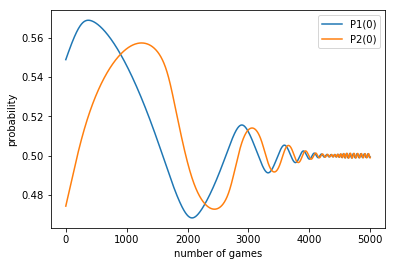

In [53]:
plt.plot(player1_proba0, label="P1(0)")
plt.plot(player2_proba0, label="P2(0)")
plt.xlabel('number of games')
plt.ylabel('probability')
plt.legend(loc='best')
plt.show()

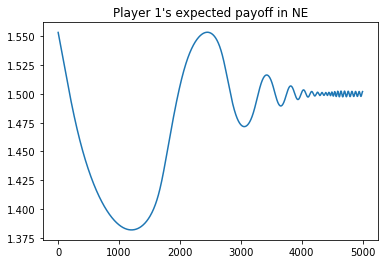

expected reward = 1.49976


In [54]:
plt.plot(losses)
plt.title("Player 1's expected payoff in NE")
plt.show()
print('expected reward =',np.mean(losses[-100:]))

# The strategies still converge to the mixed strategy NE!!

____
# Prisoner's dilemma

  | 0    | 1    |
 ------|------|------|
 0     |   (-1,-1)  | (-3,0)|
 1     |   (0,-3)  | (-2,-2)|

In [55]:
agent = GameAgent(n_actions=2, n_features=2, learning_rate=1e-3)

In [56]:
state = [[0,1]]
oppo_state = [[1,0]]
p = agent.sess.run(agent.pi_probs, {agent.tfs: state})[0]
p_ = agent.sess.run(agent.pi_probs, {agent.tfs: oppo_state})[0]
player1_proba0 = [p[0]]
player2_proba0 = [p_[0]]
losses = []
eps = 500

for ep in range(eps):
    agent.remember(state, oppo_state, 0, 0, -1)
    agent.remember(state, oppo_state, 0, 1, -3)
    agent.remember(state, oppo_state, 1, 0, 0)
    agent.remember(state, oppo_state, 1, 1, -2)
    agent.process_memory()
    agent.replay(5)
    
    agent.remember(oppo_state, state, 0, 0, -1)
    agent.remember(oppo_state, state, 0, 1, -3)
    agent.remember(oppo_state, state, 1, 0, 0)
    agent.remember(oppo_state, state, 1, 1, -2)
    agent.process_memory()  
    agent.replay(3)
    
    p = agent.sess.run(agent.pi_probs, {agent.tfs: state})[0]
    p_ = agent.sess.run(agent.pi_probs, {agent.tfs: oppo_state})[0]
    oppo_pi_probs = agent.sess.run(agent.pi_probs, {agent.tfs: oppo_state})
    losses += [-agent.sess.run(agent.loss, {agent.tfs: state, agent.oppo_pi_probs: oppo_pi_probs, 
                         agent.tfa: [0,0,1,1], agent.tfa_oppo:[0,1,0,1], agent.tfdc_r: [-1,-3,0,-2]})]
    player1_proba0 += [p[0]]
    player2_proba0 += [p_[0]]

In [57]:
print('optimal strategy :')
print('P1(0) =', np.mean(player1_proba0))
print('P2(0) =', np.mean(player2_proba0))

optimal strategy :
P1(0) = 0.0134581
P2(0) = 0.0082977


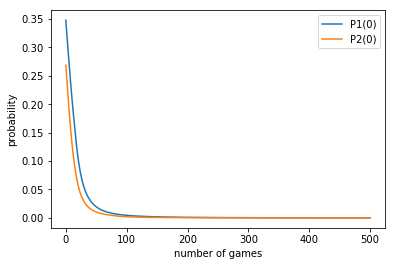

In [58]:
plt.plot(player1_proba0, label="P1(0)")
plt.plot(player2_proba0, label="P2(0)")
plt.xlabel('number of games')
plt.ylabel('probability')
plt.legend(loc='best')
plt.show()

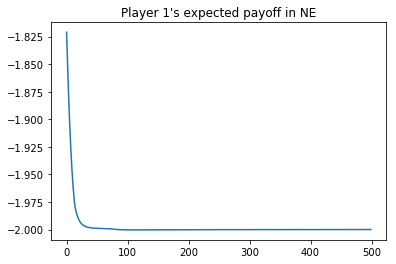

expected reward = -2.00003


In [59]:
plt.plot(losses)
plt.title("Player 1's expected payoff in NE")
plt.show()
print('expected reward =',np.mean(losses[-100:]))

# The result is the pure NE, where both prisoners defect (lower right corner)

____
# Some maths

For normal matching pennies games, if we write the expected reward for both players using the following table:

  | q    | 1-q    |
 ------|------|------|
 p     |   (1,-1)  | (-1,1)|
 1-p     |   (-1,1)  | (1,-1)|

Then $\mathbb{E}(R_1) = (1-2p)(1-2q).$

If we play as the first player, then our objective is to maximize this expectation given the opponent's strategy, i.e. maximize $\mathbb{E}_{q\ \text{fixed}}(R_1).$

Therefore, we need to follow the gradient of $p$ (here it's just the derivative) using gradient $\textbf{ascent}$ since we want to maximize the reward. We assume that $p$ and $q$ are both functions over $t$, the time (or the number of steps).

After calculation, we get $p' = 4q-2$. And analogously, $q' = 2-4p$ by differentiating $\mathbb{E}_{p\ \text{fixed}}(R_2)$ with respect to $p$ (note that the derivative is negative in $p$ since it's a zero sum game).

If we solve the system
\begin{align}
p' & = 4q-2 \quad ...\text{(1)}\\
q' & = 2-4p \quad ...\text{(2)}
\end{align}
as it stands, we can differentiate (1) to get a second order differential equation in $q$.

More precisely,
\begin{align}
p'' & = 4q' \hspace{1cm}\text{by differentiating (1) w.r.t}\space q\\
& = -16p+8 \hspace{1cm}\text{using (2)}
\end{align}

Therefore, $p'' + 16p = 8$, which is a canonical second order differential equation that we can solve by hand.

The general solution is $p = A\cos(4t+\phi) + 0.5$, where $A$ and $\phi$ are constants.

As we can see, the solution will oscillate around the optimal value, $\textit{0.5}$, but will $\textbf{never}$ converge to it.

To get a convergent $p$ (and also $q$), we need to use $\textbf{asynchronous update}$.

In my implementation, I updated $p$ first then $q$. This helps us have both $p$ and $q$ converge.

This slight modification changes equation (2) to
$$q' = 2-4(p+\eta p') \quad ...\text{(3)}$$
where $\eta$ is a small value, equal to the learning rate (usually between $10^{-2}$ and $10^{-5}$, depending on the problem).

Now if we combine (1) and (3), we get
\begin{align}
p'' & = 4q' \hspace{3cm}\text{by differentiating (1) w.r.t}\space q\\
& = -16p-16\eta p'+8 \hspace{1cm}\text{using (3)}
\end{align}

Therefore, $p'' +16\eta p' + 16p = 8$, whose solution is now convergent.

After calculation (omitted here), $p = Ae^{\alpha t}\cos(4t+\phi) + 0.5$, where $A$ and $\phi$ are constants, and $\alpha = -8\eta$.

The negative sign in the exponential function means that the first term will behave as the function below, and finally tends to zero at infinity.

<img src="https://undergroundmathematics.org/product-rule/r9312/images/sketch1.png">

Hence, $\displaystyle \lim_{t\rightarrow \infty}(p) = 0.5$, which is the optimal strategy (the strategy for the mixed strategy NE). Similarly, $\displaystyle \lim_{t\rightarrow \infty}(q) = 0.5$.

We also showed that in other games (other than zero sum game), the strategies converge to one of the (pure) NE.